In [41]:
# go wide screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [42]:
import numpy as np
import spectrum
import math


from astropy.io import fits
import spectrum
from matplotlib import pyplot as plt
import numpy as np
from astropy.stats import biweight_midvariance as bwtmv
import argparse
import sys


In [43]:
%matplotlib inline

In [44]:
from matplotlib import pyplot as plt

In [45]:
from astropy.io import ascii

In [46]:
#generic gaussian
def gauss(sigma, xsq, norm=True):
    if norm:
        return 1./(sigma * np.sqrt(2. * np.pi) ) * np.exp( -xsq/(2. * sigma**2.))
    else:
        return np.exp( -xsq/(2. * sigma**2.))


def gauss3D(xc, yc, zc, sigmaxy, sigmaz, XX, YY, ZZ):
    RRSQ = (XX - xc)**2 + (YY - yc)**2 
    g = gauss(sigmaxy, RRSQ, norm=True) * gauss(sigmaz, (ZZ - zc)**2., norm=True)
    return g


In [47]:
from scipy.optimize import least_squares

fit_iteration_count = 0

def peval(p, XX, YY, ZZ):
    A, xc, yc, zc, sigmaxy, sigmaz = p
    g = gauss3D(xc, yc, zc, sigmaxy, sigmaz, XX, YY, ZZ) /  2.5066
    #g = g/np.sum(g)
    model = A * g
    #print("X", np.sum(g), np.sum(model))
    return model

def resid(p, XX, YY, ZZ, CC, EE, ii, DEBUG=False): 
    global fit_iteration_count
    model = peval(p, XX[ii], YY[ii], ZZ[ii])
    A, xc, yc, zc, sigmaxy, sigmaz = p
    res = (CC[ii] - model)/EE[ii]
    if DEBUG:
        print( A, xc, yc, zc, sigmaxy, sigmaz, np.sum(res**2.) /np.sum(ii) )
    fit_iteration_count += 1
    return res
    
def rchisq(p, XX, YY, ZZ, CC, EE, ii):
    """
    Compute reduced chisq.
    """
    model = peval(p, XX[ii], YY[ii], ZZ[ii])
    A, xc, yc, zc, sigmaxy, sigmaz = p
    res = (CC[ii] - model)/EE[ii]
    return np.sum(res**2.)/(np.sum(ii) - len(p))

In [48]:
# Contrals if the segmantation map shoudl be used
# to resirict the fit to the segmented pixels.
USEMAP = True

# Debug mode
DEBUG = True


dxmax = 4.
dymax = 4.
dzmax = 10.


In [73]:
fcube = "../data/sfgama09Efin_013.fits.gz"
fnoisemodel = "../data/sfgama09Efin_013.detect_noise_model"
fcatalog = "../data/sfgama09Efin_013.cat"
fmap = "../data/mapgama09Efin_013.fits.gz"

In [50]:
print("Reading datacube {} ...".format(fcube))
c = spectrum.readSpectrum(fcube)

Reading datacube ../data/sfgama09Ffin_078.fits.gz ...


In [51]:
if USEMAP:
    print("Reading map {} ...".format(fcube))
    m = spectrum.readSpectrum(fmap)

Reading map ../data/sfgama09Ffin_078.fits.gz ...


In [52]:
print("Reading noisemodel {} ...".format(fnoisemodel))
with open(fnoisemodel) as f:
    ll = f.readlines()
p = [float(l) for l in ll]

wl = c.grid()

Reading noisemodel ../data/sfgama09Ffin_078.detect_noise_model ...


In [53]:
print("Reading catalog {} ...".format(fcatalog))
t = ascii.read(fcatalog)

Reading catalog ../data/sfgama09Ffin_078.cat ...


In [54]:
# I am sure her is better ways to do this...
# here we evaluate the noise model at every wavelngth (= slice) and 
# create a cube where each slice contans that value
WW = np.ones_like(c.data)

for i in range(len(wl)):
    WW[i] = WW[i] * wl[i]
    
EE = np.polyval(p,WW)

In [55]:
# build meshgrids for easy numerical navigation through the cubes
xx = np.arange(c.data.shape[2])
yy = np.arange(c.data.shape[1])
zz = np.arange(c.data.shape[0])

YY,ZZ,XX = np.meshgrid(yy, zz, xx)

Fitting gaussian model to source 122 ...
    Initial guesses are:  [2.3572, 24.54, 77.21, 517.27, 1.1122156180891811, 4.55]
   Bestfit parameters after 49 iterations are:  [ 11.28579734  23.70628855  78.23496272 516.52040775   3.43026268
   9.37970637]
   Reduced chisq is: 0.20132335313665908


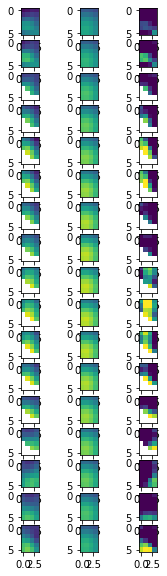

In [56]:
for r in t[t['id'] == 122]:
    
    id = r["id"]
    print("Fitting gaussian model to source {} ...".format(id))
    
    x_com, y_com, z_com = r["x_com"], r["y_com"], r["z_com"]
    xmin, ymin, zmin = r["xmin"], r["ymin"], r["zmin"]
    xmax, ymax, zmax = r["xmax"], r["ymax"], r["zmax"]
    dx, dy, dz = r["dx"], r["dy"], r["dz"]
    counts = r["counts"]

    if (xmax-xmin) < 4:
        print("   x extend is less than 5. Skipping ....")
        continue
    
    if (ymax-ymin) < 4:
        print("   y extend is less than 5. Skipping ....")
        continue
    
    if (zmax-zmin) < 4:
        print("   z extend is less than 5. Skipping ....")
        continue
    
    if dx > dxmax:
        print("   dx = {} is larger than threshold {}. Skipping ....".format(dx, dxmax))
        continue
    if dy > dymax:
        print("   dy = {} is larger than threshold {}. Skipping ....".format(dy, dymax))
        continue
    if dz > dzmax:
        print("   dz = {} is larger than threshold {}. Skipping ....".format(dz, dzmax))
        continue


    if not USEMAP:
        ii  = XX >= xmin
        ii *= XX <= xmax
        ii *= YY >= ymin
        ii *= YY <= ymax
        ii *= ZZ >= zmin
        ii *= ZZ <= zmax
    else:
        ii = m.data == id
    #model = gauss3D(x_com, y_com, z_com, np.sqrt(dx**2. + dy**2.), dz, XX, YY, ZZ)

    sigmaxy = np.sqrt(dx**2. + dy**2.)/1.414

    p0 = [counts, x_com, y_com, z_com, sigmaxy, dz]
    print("    Initial guesses are: ", p0)
    #model = peval(p0, XX, YY, ZZ)


    CC = c.data
    #EE = np.ones_like(c.data)*2.5e-3
    #try:
    bestfit = least_squares(resid, p0, args=(XX, YY, ZZ, CC, EE, ii))

    model = peval(bestfit.x, XX, YY, ZZ)

    print("   Bestfit parameters after {} iterations are: ".format(fit_iteration_count), bestfit.x)
    print("   Reduced chisq is: {}".format(rchisq(bestfit.x, XX, YY, ZZ, CC, EE, ii)))

    if DEBUG:
        # peak in pixel counts
        cnts_max = np.nanmax(c.data[int(z_com)][ymin:ymax,xmin:xmax])
        N = zmax-zmin
        f = plt.figure(figsize=[3,10])
        for i, z in enumerate( range(zmin,zmax) ):
            plt.subplot(N, 3, i*3+1)
            plt.imshow( c.data[z][ymin:ymax,xmin:xmax], vmin=0, vmax=cnts_max )

            plt.subplot(N, 3, i*3+2)
            plt.imshow( model[z][ymin:ymax,xmin:xmax], vmin=0, vmax=cnts_max )

            plt.subplot(N, 3, i*3+3)
            plt.imshow( c.data[z][ymin:ymax,xmin:xmax] - model[z][ymin:ymax,xmin:xmax], vmin=-cnts_max/10., vmax=cnts_max/10.  )
        plt.show()
    #except:
    #    print("    Fit failed.")


In [34]:
resid(p0, XX, YY, ZZ, CC, EE, ii, DEBUG=True)

0.9914 168.55 291.97 449.5 1.4594839115841696 1.39 4.1866182056384575


array([ 3.24734808,  2.77091635,  1.84382568,  2.77231999,  0.35062295,
        0.76272627,  2.04765712,  2.742666  ,  1.03227099, -0.47666361,
       -0.12674989,  1.38911924,  2.47732421,  1.43885334,  0.09167019,
        0.05137985,  1.11782288, -1.52458525, -0.84638311,  1.40613924,
        2.82726982,  2.67542399, -0.53226717, -2.5423161 , -1.86274389,
        0.82130675,  2.63800086,  0.39549993, -1.31006172, -1.11846358,
        0.80685945,  0.58444122,  1.80362334,  2.65064189, -2.09278427,
       -1.62570424,  0.59543837,  2.10680285, -0.84452199, -3.0093934 ,
       -2.55299303,  0.15438091,  2.13374851,  2.25486455,  0.38360951,
       -1.41590344, -1.35512685,  0.61750458,  2.50838236,  1.79556801,
        0.80905453,  2.69854049,  2.47715994,  2.04091849,  2.5897235 ,
        2.74822926,  2.25332178,  2.77764241,  3.48193556,  3.28053417,
        2.74317332,  2.97867155,  3.11555145,  2.65253567,  2.72892823,
        3.00893199])

In [71]:
len(t)

58

In [35]:
model[z][ymin:ymax,xmin:xmax]

array([[0.01188249, 0.01321841, 0.01430559, 0.01506216, 0.01542848,
        0.01537495, 0.01490593],
       [0.01229344, 0.01367556, 0.01480035, 0.01558307, 0.01596206,
        0.01590668, 0.01542144],
       [0.01237354, 0.01376467, 0.01489678, 0.01568461, 0.01606607,
        0.01601033, 0.01552193],
       [0.01211628, 0.01347849, 0.01458706, 0.01535851, 0.01573204,
        0.01567746, 0.01519921],
       [0.01154248, 0.01284018, 0.01389626, 0.01463117, 0.01498701,
        0.01493501, 0.01447941]])

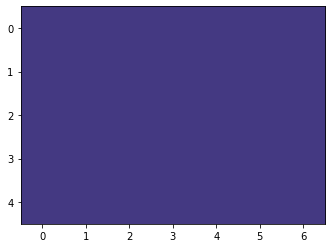

In [39]:
plt.imshow( EE[z][ymin:ymax,xmin:xmax], vmin=0, vmax=cnts_max )

In [40]:
EE[z][ymin:ymax,xmin:xmax]

array([[0.00423942, 0.00423942, 0.00423942, 0.00423942, 0.00423942,
        0.00423942, 0.00423942],
       [0.00423942, 0.00423942, 0.00423942, 0.00423942, 0.00423942,
        0.00423942, 0.00423942],
       [0.00423942, 0.00423942, 0.00423942, 0.00423942, 0.00423942,
        0.00423942, 0.00423942],
       [0.00423942, 0.00423942, 0.00423942, 0.00423942, 0.00423942,
        0.00423942, 0.00423942],
       [0.00423942, 0.00423942, 0.00423942, 0.00423942, 0.00423942,
        0.00423942, 0.00423942]])

In [74]:
fit_iteration_count = 0

#generic gaussian
def gauss(sigma, xsq, norm=True):
    if norm:
        return 1./(sigma * np.sqrt(2. * np.pi) ) * np.exp( -xsq/(2. * sigma**2.))
    else:
        return np.exp( -xsq/(2. * sigma**2.))


def gauss3D(xc, yc, zc, sigmaxy, sigmaz, XX, YY, ZZ):
    RRSQ = (XX - xc)**2 + (YY - yc)**2 
    g = gauss(sigmaxy, RRSQ, norm=True) * gauss(sigmaz, (ZZ - zc)**2., norm=True)
    return g


fit_iteration_count = 0

def peval(p, XX, YY, ZZ):
    A, xc, yc, zc, sigmaxy, sigmaz = p
    g = gauss3D(xc, yc, zc, sigmaxy, sigmaz, XX, YY, ZZ) /  2.5066
    #g = g/np.sum(g)
    model = A * g
    #print("X", np.sum(g), np.sum(model))
    return model

def resid(p, XX, YY, ZZ, CC, EE, ii, DEBUG=False): 
    global fit_iteration_count
    fit_iteration_count += 1
    model = peval(p, XX[ii], YY[ii], ZZ[ii])
    A, xc, yc, zc, sigmaxy, sigmaz = p
    res = (CC[ii] - model)/EE[ii]
    if DEBUG:
        print( A, xc, yc, zc, sigmaxy, sigmaz, np.sum(res**2.) /np.sum(ii) )
    return res
    
def rchisq(p, XX, YY, ZZ, CC, EE, ii, model="none"):
    """
    Compute reduced chisq.
    """
    if type(model) == type(None):
        _model = peval(p, XX[ii], YY[ii], ZZ[ii])
    else:
        _model = model[ii]
    A, xc, yc, zc, sigmaxy, sigmaz = p
    res = (CC[ii] - _model)/EE[ii]
    return np.sum(res**2.)/(np.sum(ii) - len(p))


def fit_pointsource(id, x_com, y_com, z_com, xmin, ymin, zmin, xmax, ymax, zmax, dx, dy, dz, counts,\
                    CC, MM, EE, USEMAP, DEBUG, max_nfev=5000):
    global fit_iteration_count

    if not USEMAP:
        ii  = XX >= xmin
        ii *= XX <= xmax
        ii *= YY >= ymin
        ii *= YY <= ymax
        ii *= ZZ >= zmin
        ii *= ZZ <= zmax
    else:
        ii = MM == id

    sigmaxy = np.sqrt(dx**2. + dy**2.)/1.414

    p0 = [counts, x_com, y_com, z_com, sigmaxy, dz]
    print("    Initial guesses are: ", p0)

    

    bestfit = least_squares(resid, p0, args=(XX, YY, ZZ, CC, EE, ii, DEBUG), max_nfev=max_nfev)

    model = peval(bestfit.x, XX, YY, ZZ)

    if DEBUG:
        # peak in pixel counts
        cnts_max = np.nanmax(CC[int(z_com)][ymin:ymax,xmin:xmax])
        N = zmax-zmin
        f = plt.figure(figsize=[3,10])
        for i, z in enumerate( range(zmin,zmax) ):
            plt.subplot(N, 3, i*3+1)
            plt.imshow( CC[z][ymin:ymax,xmin:xmax], vmin=0, vmax=cnts_max )

            plt.subplot(N, 3, i*3+2)
            plt.imshow( model[z][ymin:ymax,xmin:xmax], vmin=0, vmax=cnts_max )

            plt.subplot(N, 3, i*3+3)
            plt.imshow( CC[z][ymin:ymax,xmin:xmax] - model[z][ymin:ymax,xmin:xmax], \
                       vmin=-cnts_max/10., vmax=cnts_max/10.  )
        #plt.show()
        f.tight_layout(figsize=[20,10])
        plt.savefig("fit_pointsource.pdf")
        
    return bestfit


for r in t[t['id'] == 20]:
    
    id = r["id"]
    print("Fitting gaussian model to source {} ...".format(id))
    
    x_com, y_com, z_com = r["x_com"], r["y_com"], r["z_com"]
    xmin, ymin, zmin = r["xmin"], r["ymin"], r["zmin"]
    xmax, ymax, zmax = r["xmax"], r["ymax"], r["zmax"]
    dx, dy, dz = r["dx"], r["dy"], r["dz"]
    counts = r["counts"]

    if (xmax-xmin) < 4:
        print("   x extend is less than 5. Skipping ....")
        continue
    
    if (ymax-ymin) < 4:
        print("   y extend is less than 5. Skipping ....")
        continue
    
    if (zmax-zmin) < 4:
        print("   z extend is less than 5. Skipping ....")
        continue
    
    if dx > dxmax:
        print("   dx = {} is larger than threshold {}. Skipping ....".format(dx, dxmax))
        continue
    if dy > dymax:
        print("   dy = {} is larger than threshold {}. Skipping ....".format(dy, dymax))
        continue
    if dz > dzmax:
        print("   dz = {} is larger than threshold {}. Skipping ....".format(dz, dzmax))
        continue


    if not USEMAP:
        print("Not using map.")
        ii  = XX >= xmin
        ii *= XX <= xmax
        ii *= YY >= ymin
        ii *= YY <= ymax
        ii *= ZZ >= zmin
        ii *= ZZ <= zmax
    else:
        ii = m.data == id
    print("{} sum(ii) = {}".format(id, np.sum(ii)))
    #model = gauss3D(x_com, y_com, z_com, np.sqrt(dx**2. + dy**2.), dz, XX, YY, ZZ)

    sigmaxy = np.sqrt(dx**2. + dy**2.)/1.414

    p0 = [counts, x_com, y_com, z_com, sigmaxy, dz]


    CC = c.data

    print("fit_pointsource", r, x_com, y_com, z_com, xmin, ymin, zmin, xmax, ymax, zmax, dx, dy, dz, counts,\
                CC, m.data, EE, True, True)
    p = fit_pointsource(r, x_com, y_com, z_com, xmin, ymin, zmin, xmax, ymax, zmax, dx, dy, dz, counts,\
                CC, m.data, EE, True, True)
    
    if not bestfit.success:
        print("    Fit failed.")
    else:
        p = bestfit.x
        print("P: ", p)
        psfit_cnts, psfit_xc, psfit_yc, psfit_zc, psfit_sigxy, psfit_sigz = p
        # integrate model
        model = peval(p, XX, YY, ZZ)
        psfit_rchisq = rchisq(p, XX, YY, ZZ, CC, EE, ii, model=model)

        print("   Bestfit parameters after {} iterations are: ".format(fit_iteration_count), p)
        print("   Reduced chisq is: {}".format(psfit_rchisq) )

        fit_iteration_count = 0


Fitting gaussian model to source 20 ...
   x extend is less than 5. Skipping ....
